# 1.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree

from IPython.display import Image

import pickle

import time
import warnings

# Tempo de processamento
time_agora = time.time()

###### 1.2 Helper Functions

In [2]:
# Função buscar outlier pelo método do 6 Sigma
def buscar_outlier(df, series):
    média = df[series].mean()
    desvio_padrão = df[series].std()
    lis = média - (desvio_padrão * 3)
    lss = média + (desvio_padrão * 3)
    lista_outliers = df[(df[series] < lis) | (df[series] > lss)].index
    return lista_outliers, lis, lss

###### 1.3 Loading Dataset

In [3]:
df = pd.read_csv(r'D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\data\\raw\\train.csv')

test = df.sample(frac=0.1)
test_indices = test.index
df = df.drop(test_indices)

# 2.0 Data Description

## 2.1 General Analysis

##### 2.1.0 Main insights:

###### Response:
1. Desbalanceada com 12% de eventos positivos

###### Vehicle_Age:
1. Mais da metade dos clientes possuem carros com menos de 1 ano

###### Region_Code:
1. 53 regiões
2. 28% dos clientes está contido na região 28. 
3. 50% dos dados estão contidos nas 5 regiões mais numerosas

###### Policy_Sales_Channel:
1. Há 157 Policy_Sales_Channel e aproximadamente um terço das amostras está contido no canal 152

###### Vintage:
1. Feature categórica, há 290 categorias em Vintage

###### Age:
1. Range de idade de 25 até 85 anos, aparentemente sem erros de input

##### 2.1.1 Data dimensions

In [4]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 342998
Number of columns: 12


##### 2.1.2 Data types

In [5]:
df.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

##### 2.1.3 Look table

In [6]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Gender, Vehicle_Age, Vehicle_Damage precisam ser transformados para que possam haver estudos de correlação

##### 2.1.4 Changing Interesting datatypes

In [7]:
le_gender = LabelEncoder().fit(df['Gender'])
df['Gender_'] = le_gender.transform(df['Gender'])

le_vehicle_damage = LabelEncoder().fit(df['Vehicle_Damage'])
df['Vehicle_Damage_'] = le_vehicle_damage.transform(df['Vehicle_Damage'])

le_vehicle_age = LabelEncoder().fit(df['Vehicle_Age'])
df['Vehicle_Age_'] = le_vehicle_age.transform(df['Vehicle_Age'])

##### 2.1.5 Segregating feature types

In [8]:
features_id = ['id']
features_string = ['Gender', 'Vehicle_Damage', 'Vehicle_Age']
features_categóricas = ['Gender_', 'Vehicle_Damage_', 'Vehicle_Age_', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Policy_Sales_Channel', 'Vintage']
features_numéricas = ['Age', 'Annual_Premium']
target = ['Response']

##### 2.1.6 Check NaN values

In [9]:
df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
Gender_                 0
Vehicle_Damage_         0
Vehicle_Age_            0
dtype: int64

Sem valores nulos

## 2.2 Descriptive Statistics

### 2.2.1 Target

In [10]:
print(f'A porcentagem de interessados no produto é: {round(df["Response"].mean(), 2) * 100} %')

A porcentagem de interessados no produto é: 12.0 %


Desbalanceada

### 2.2.2 Numerical Features

In [11]:
df[features_numéricas].describe()

,Age,Annual_Premium
count,342998.000000,342998.000000
mean,38.816777,30578.060817
std,15.508080,17231.389317
min,20.000000,2630.000000
25%,25.000000,24422.000000
50%,36.000000,31674.000000
75%,49.000000,39407.000000
max,85.000000,540165.000000


Range de idade entre 20 e 85 anos, sem indícios de erros de inputs, Annual_Premium com possíveis outliers

In [12]:
# Central tendency
ct1 = pd.DataFrame(df[features_numéricas].apply(np.mean)).T
ct2 = pd.DataFrame(df[features_numéricas].apply(np.median)).T

# Dispersion
d1 = pd.DataFrame(df[features_numéricas].apply(np.std)).T
d2 = pd.DataFrame(df[features_numéricas].apply(min)).T
d3 = pd.DataFrame(df[features_numéricas].apply(max)).T
d4 = pd.DataFrame(df[features_numéricas].apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df[features_numéricas].apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df[features_numéricas].apply(lambda x: x.kurtosis())).T

# Concat
temp = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
temp.columns = 'min max range mean median std skew kurtosis'.split()
temp

,min,max,range,mean,median,std,skew,kurtosis
Age,20.0,85.0,65.0,38.816777,36.0,15.508058,0.672032,-0.566666
Annual_Premium,2630.0,540165.0,537535.0,30578.060817,31674.0,17231.364198,1.779755,33.683827


1. Idade com média e mediana próximas, dados centralizados na média, skew baixa, o que reforça distribuição centralizada na média, skew pouco positiva, o que sugere cauda esquerda mais pesada, kurtosis baixa e negativa, o que sugere uma distribuição um pouco mais plana em relação a uma normal com mesma média e desvio padrão, uma distribuição próxima a uma NORMAL
2. Prêmio Anual com média e mediana próximos, o que sugere dados centralizados na média, skew baixa e positiva, o que sugere dados centralizados na média com uma cauda esquerda mais pesada, kurtosis bastante alto, o que sugere um pico bastante elevado, uma distribuição próxima a uma POISSON

### 2.2.3 Categorical Features

In [13]:
df[features_categóricas].astype('category').describe().T

,count,unique,top,freq
Gender_,342998.0,2.0,1.0,185621.0
Vehicle_Damage_,342998.0,2.0,1.0,173205.0
Vehicle_Age_,342998.0,3.0,0.0,180136.0
Driving_License,342998.0,2.0,1.0,342276.0
Region_Code,342998.0,53.0,28.0,95824.0
Previously_Insured,342998.0,2.0,0.0,185807.0
Policy_Sales_Channel,342998.0,152.0,152.0,121266.0
Vintage,342998.0,290.0,158.0,1268.0


Sexo relativamente balanceado com a maioria de mulheres, maior parte dos clientes possuem veículos com menos de 1 ano, maior parte dos clientes já teve danos em seu veículo, habilitação para dirigir balanceado, há 53 regiões diferentes e por volta de 30% dos clientes estão contidos na região 28, um pouco mais que 50% dos clientes não possuem seguro veicular, há 157 canais de vendas, e por volta de 35% dos clientes estão contidos no canal 152.

# 3.0 Feature Engineering

###### 3.1 Policy_Sales_Channel Response Mean

In [14]:
group = df[['Policy_Sales_Channel', 'Response']].groupby('Policy_Sales_Channel').agg({'Response':'mean'})
map_policy_sales_channel_response_mean = group.to_dict()['Response']
df['Policy_Sales_Channel_Response_Mean'] = df['Policy_Sales_Channel'].map(map_policy_sales_channel_response_mean)

In [15]:
df.corr()['Policy_Sales_Channel_Response_Mean'].sort_values(ascending=False)[1:]

Age                     0.638581
Vehicle_Damage_         0.435632
Response                0.264121
Gender_                 0.169148
Region_Code             0.027987
id                      0.000745
Annual_Premium          0.000589
Vintage                -0.002585
Driving_License        -0.033167
Previously_Insured     -0.418578
Policy_Sales_Channel   -0.530596
Vehicle_Age_           -0.573135
Name: Policy_Sales_Channel_Response_Mean, dtype: float64

Correlações fortes com Age, correlações moderadas com Vehicle_Damage, Vehicle_Age, Previously_Insured, correlação fraca com Response

###### 3.2 Region_Code Response Mean

In [16]:
group = df[['Region_Code', 'Response']].groupby('Region_Code').agg({'Response':'mean'})
map_region_code_response_mean = group.to_dict()['Response']
df['Region_Code_Response_Mean'] = df['Region_Code'].map(map_region_code_response_mean)

In [17]:
df.corr()['Region_Code_Response_Mean'].sort_values(ascending=False)[1:]

Policy_Sales_Channel_Response_Mean    0.373854
Age                                   0.316421
Annual_Premium                        0.250434
Vehicle_Damage_                       0.196153
Response                              0.138770
Region_Code                           0.080719
Gender_                               0.042989
Vintage                               0.000327
id                                   -0.001998
Driving_License                      -0.016770
Previously_Insured                   -0.180282
Vehicle_Age_                         -0.207109
Policy_Sales_Channel                 -0.286261
Name: Region_Code_Response_Mean, dtype: float64

Correlações fracas com Age, Annual_Premium, Policy_Sales_Channel e Vehicle_Age

###### 3.3 High_Age

In [18]:
df.loc[df['Age']<30, 'High_Age'] = 0
df['High_Age'].fillna(1, inplace=True)

###### 3.4 Log_Annual_Premium

In [19]:
df['Log_Annual_Premium'] = np.log1p(df['Annual_Premium'])

###### 3.5 Annual_Premium_Variated

In [20]:
df.loc[df['Annual_Premium']==2630, 'Annual_Premium_Variated'] = 0
df['Annual_Premium_Variated'].fillna(1, inplace=True)

Feature **Annual_Premium_Variated** não contribuiu com o modelo e foi removida posteriormente

###### 3.6 High_Annual_Premium

In [21]:
temp = np.percentile(df.loc[df['Annual_Premium_Variated']==1, 'Annual_Premium'], 75)
df.loc[df['Annual_Premium']>= temp, 'High_Annual_Premium'] = 1
df['High_Annual_Premium'].fillna(0, inplace=True)

Feature **High_Annual_Premium** não contribuiu com o modelo e foi removida posteriormente

# 4.0 Business Hypothesis

In [22]:
Image('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\mindmap_hypotheis.png')

FileNotFoundError: No such file or directory: 'D:\My Drive\Pessoal\Projetos\insurance_sales_predict\insurance_sales_predict\mindmap_hypotheis.png'

FileNotFoundError: No such file or directory: 'D:\My Drive\Pessoal\Projetos\insurance_sales_predict\insurance_sales_predict\mindmap_hypotheis.png'

<IPython.core.display.Image object>

###### Corretora:
1. Contatos mais diretos com os clientes deveriam gerar mais vendas

###### Clientes:
1. Clientes localizados em regiões mais populosas deveriam comprar mais
2. Clientes do gênero feminino deveriam comprar mais
3. Clientes mais velhos deveriam comprar mais

###### Seguro de Vida:
1. Contas de Seguro de Vida com valores mais altos deveriam gerar mais vendas
2. Contas com tempo de aquisição vigente maior deveriam gerar mais vendas

###### Relação do Cliente com o Automóvel:
1. Clientes que já acionaram o seguro no passado deveriam comprar mais
2. Clientes com veículos mais novos deveriam comprar mais
3. Clientes que não possuem seguro de automóvel deveriam comprara mais.
4. Clientes habilitados deveriam comprar mais.

# 5.0 Exploratory Data Analysis

## 5.1 Principais Insights:

### Espaço Amostral
1. 6 dimensões parecem explicar 90% de toda variabilidade das features
2. Annual_Premium transformada por log apresenta uma shape semelhante a uma normal
3. 4 features binárias, 2 numéricas, 1 categórica e 2 categóricas com excessivas categorias e portanto foram transformadas em numéricas.

### Features Analysis

###### Response:
1. Desbalanceada com 12% de eventos positivos
2. Correlação fraca com Vehicle_Damage e correlação fraca negativa com Previously_Insured

###### Gender:
1. Balanceada
2. Correlações muito fracas
3. Homens se interessam 30% mais no produto em relação às mulheres

###### Vehicle_Age:
1. Mais da metade dos clientes possuem carros com menos de 1 ano
2. Correlação moderada negativa com Age, fraca positiva com Policy_Sales_Channel
3. Médias de response bastante distintas

###### Vehicle_Damage:
1. Balanceada
2. Correlação muito forte negativa com Previously_Insured, fraca negativa com Policy_Sales_Channel, fraca positiva com Response e Age
3. Clientes que já tiveram danos no seu veículo tem 24% de response, enquanto clientes que não tiveram danos têm por volta de 1%

###### Driving_License:
1. Correlações muito fracas
2. 99% dos clientes são habilitados
3. Habilitados apresentam 5% de interesse no produto, não habilitados apresentam 12% de interesse no produto.

###### Previously_Insured:
1. 45% dos clientes já possuem seguro veicular
2. Clientes que já possuem seguro têm interesse quase zero pelo produto
3. Correlação muito forte negativa com Vehicle_Damage, fraca negativa com Response e Age, e fraca positiva com Policy_Sales_Channel

###### Region_Code:
1. 53 regiões
2. 28% dos clientes está contido na região 28. 50% dos dados estão contidos nas 5 regiões mais numerosas
3. A região 28 (mais importante) tem por volta de 18% de probabilidade de response, segunda melhor região, atrás apenas da região 38.
4. As regiões com probabilidade de response mais alto estão com por volta de 19%, as regiões com probabilidades mais baixas estã em por volta de 4%
5. Médias de response bastante distintas, com desvios padrões baixos

###### Policy_Sales_Channel:
1. Há 157 Policy_Sales_Channel e aproximadamente um terço das amostras está contido no canal 152
2. 5 categorias contém 84.19% do total de clientes
3. Correlação moderada negativa com Age, correlação fraca negativa com Vehicle_Damage, correlação fraca positiva com Vehicle_Age e Previously_Insured
4. Médias de response por canais de Policy_Sales_Channel bastante distintas
5. Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

###### Vintage:
1. Feature categórica, há 290 categorias em Vintage

###### Age:
1. Range de idade de 25 até 85 anos, aparentemente sem erros de input
2. Apresenta uma distribuição com uma certa semelhança com uma Poison, mas com uma segunda moda em um ponto próximo aos 45 anos.
3. Sem outliers
4. A média de idade entre os que não se interessam pelo produto é de 38 anos, e dos que se interessam é de 43 anos.
5. Pessoas com mais de 30 anos apresentam um interesse relativamente maior pelo produto.
6. Correlações moderadas negativas com Policy_Sales_Channel e Vehicle_Age, fraca negativa com Previously_Insured e fraca positiva com Vehicle_Damage
7. Clientes com menos de 30 anos de idade apresentam em média 4% de interesse no produto, enquanto os clientes com 30 anos ou mais têm em média 17% interesse no produto.


###### Annual_Premium
1. 2799 em Annual_Premmium, não aparentam ser por conta de erros de input
2. Há dois grupos de clientes, um com valores fixos em 2630 dollares, e outro com valores contínuos e superiores, não há diferença significativa de média de interesse no produto entre os grupos
3. Acima do terceiro quartil da distribuição há um interesse relativo 20% maior no produto

## 5.2 Espaço Amostral

### 5.2 Principal Component Analysis

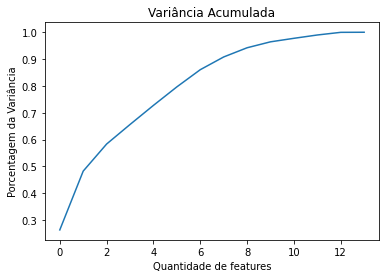

In [23]:
# drop irrelevant features
temp = df.drop(['id', 'Response', 'Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Vintage', 'Policy_Sales_Channel'], axis=1).dropna()
temp = StandardScaler().fit_transform(temp)

# model description end fit
pca = PCA()

# fiting model
pca = pca.fit(temp)

# ploting cumulative sum
np.cumsum(pca.explained_variance_ratio_)
plt.title('Variância Acumulada')
plt.xlabel('Quantidade de features')
plt.ylabel('Porcentagem da Variância')
plt.plot(np.cumsum(pca.explained_variance_ratio_));

Os autovetores indicam que 6 dimensões parecem explicar 90% de toda variabilidade das features

## 5.3 Features Analysis

#### Response

###### Principais Insights:
1. Desbalanceada com 12% de eventos positivos
2. Correlação fraca com Vehicle_Damage e correlação fraca negativa com Previously_Insured

###### General Analysis

In [24]:
df['Response'].mean()

0.123003632674243

In [25]:
df.corr()['Response'].sort_values(ascending=False)[1:]

Vehicle_Damage_                       0.355212
Policy_Sales_Channel_Response_Mean    0.264121
High_Age                              0.206622
Region_Code_Response_Mean             0.138770
Age                                   0.112537
Gender_                               0.052514
High_Annual_Premium                   0.038937
Annual_Premium                        0.023226
Region_Code                           0.011201
Driving_License                       0.010615
Log_Annual_Premium                    0.002723
Vintage                              -0.001069
id                                   -0.002061
Annual_Premium_Variated              -0.012204
Vehicle_Age_                         -0.104033
Policy_Sales_Channel                 -0.140142
Previously_Insured                   -0.341880
Name: Response, dtype: float64

Correlação fraca com Vehicle_Damage e correlação fraca negativa com Previously_Insured

#### Gender

###### Principais Insights:
1. Balanceada
2. Correlações muito fracas
3. Homens se interessam 30% mais no produto em relação às mulheres

###### General Analysis

In [26]:
df.corr()['Gender_'].sort_values(ascending=False)[1:]

Policy_Sales_Channel_Response_Mean    0.169148
High_Age                              0.159085
Age                                   0.146176
Vehicle_Damage_                       0.091994
Response                              0.052514
Region_Code_Response_Mean             0.042989
High_Annual_Premium                   0.022427
Annual_Premium                        0.003731
id                                    0.001160
Region_Code                          -0.000045
Vintage                              -0.003352
Log_Annual_Premium                   -0.013703
Driving_License                      -0.018290
Annual_Premium_Variated              -0.025740
Previously_Insured                   -0.082508
Policy_Sales_Channel                 -0.111758
Vehicle_Age_                         -0.112753
Name: Gender_, dtype: float64

Correlações muito fracas

In [27]:
le_gender.inverse_transform([0])

array(['Female'], dtype=object)

In [28]:
print(f'{round(df.loc[df["Gender_"]==0, "Response"].mean() *100, 2)}% das mulheres se interessam pelo produto.')
print(f'{round(df.loc[df["Gender_"]==1, "Response"].mean() *100, 2)}% dos homens se interessam pelo produto.')

10.43% das mulheres se interessam pelo produto.
13.89% dos homens se interessam pelo produto.


#### Age

###### Principais Insights:
1. Range de idade de 25 até 85 anos, aparentemente sem erros de input
2. Apresenta uma distribuição com uma certa semelhança com uma Poison, mas com uma segunda moda em um ponto próximo aos 45 anos.
3. Sem outliers
4. A média de idade entre os que não se interessam pelo produto é de 38 anos, e dos que se interessam é de 43 anos.
5. Pessoas com mais de 30 anos apresentam um interesse relativamente maior pelo produto.
6. Correlações moderadas negativas com Policy_Sales_Channel e Vehicle_Age, fraca negativa com Previously_Insured e fraca positiva com Vehicle_Damage

###### General Analysis

In [29]:
df.corr()['Age'].sort_values(ascending=False)[1:]

High_Age                              0.787719
Policy_Sales_Channel_Response_Mean    0.638581
Region_Code_Response_Mean             0.316421
Vehicle_Damage_                       0.267332
High_Annual_Premium                   0.146918
Gender_                               0.146176
Response                              0.112537
Annual_Premium                        0.067474
Region_Code                           0.042919
id                                    0.002068
Vintage                              -0.001344
Log_Annual_Premium                   -0.009624
Annual_Premium_Variated              -0.063888
Driving_License                      -0.078918
Previously_Insured                   -0.254810
Vehicle_Age_                         -0.521069
Policy_Sales_Channel                 -0.578500
Name: Age, dtype: float64

Correlações moderadas negativas com Policy_Sales_Channel e Vehicle_Age, fraca negativa com Previously_Insured e fraca positiva com Vehicle_Damage

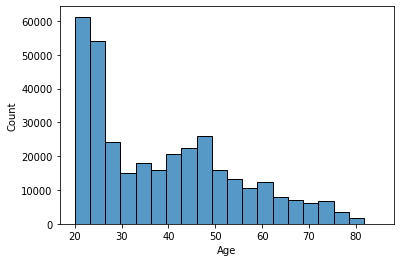

In [30]:
sns.histplot(df['Age'], bins=20);

Apresenta uma distribuição com uma certa semelhança com uma Poison, mas com uma segunda moda em um ponto próximo aos 45 anos.

In [31]:
índices, li, ls = buscar_outlier(df, 'Age')

In [32]:
df.loc[índices]

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,...,Response,Gender_,Vehicle_Damage_,Vehicle_Age_,Policy_Sales_Channel_Response_Mean,Region_Code_Response_Mean,High_Age,Log_Annual_Premium,Annual_Premium_Variated,High_Annual_Premium


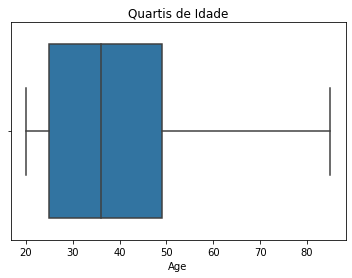

In [33]:
sns.boxplot(data=df, x='Age')
plt.title('Quartis de Idade');

sem outliers

In [34]:
print(f'A média de idade entre os que NÃO se interessam pelo produto: {round(df.loc[df["Response"]==0, "Age"].mean(), 2)}%')
print(f'A média de idade entre os que se interessam pelo produto: {round(df.loc[df["Response"]==1, "Age"].mean(), 2)}%')

A média de idade entre os que NÃO se interessam pelo produto: 38.16%
A média de idade entre os que se interessam pelo produto: 43.48%


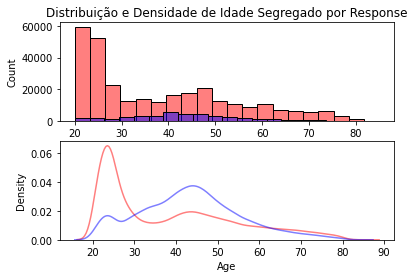

In [35]:
plt.subplot(2, 1, 1)
plt.title('Distribuição e Densidade de Idade Segregado por Response')
g = sns.histplot(df.loc[df['Response']==0, 'Age'], color='r', alpha=0.5, bins=20)
g = sns.histplot(df.loc[df['Response']==1, 'Age'], color='b', alpha=0.5, bins=20)
plt.subplot(2, 1, 2)
g = sns.kdeplot(df.loc[df['Response']==0, 'Age'], color='r', alpha=0.5)
g = sns.kdeplot(df.loc[df['Response']==1, 'Age'], color='b', alpha=0.5)

Pessoas mais velhas apresentam maior interesse no produto

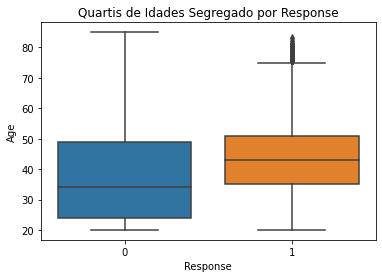

In [36]:
sns.boxplot(x='Response', y='Age', data=df)
plt.title('Quartis de Idades Segregado por Response');

Pessoas mais velhas apresentam interesse maior pelo produto

Adicionando aleatoriedade

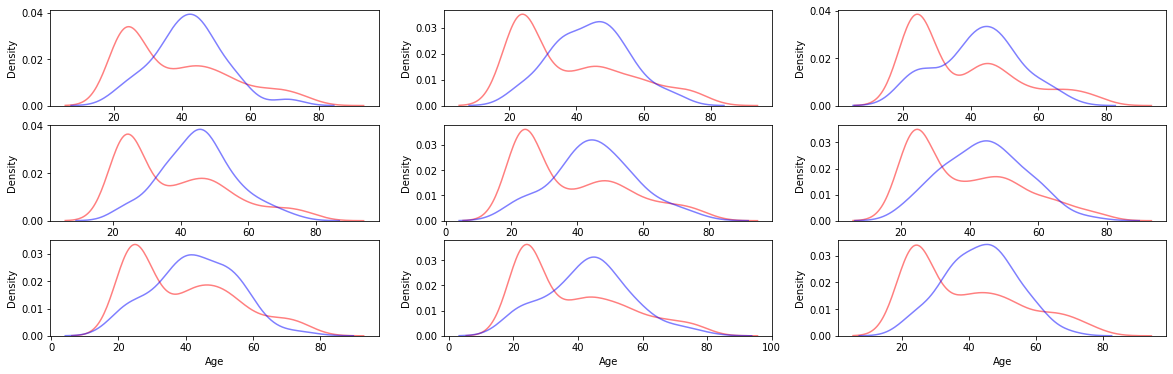

In [37]:
df.reset_index(drop=True, inplace=True)
plt.figure(figsize=(20, 6))
for i in range(1, 10):
    random_index = np.random.choice(df.index, 500, replace=False)
    temp = df.loc[random_index]
    plt.subplot(3, 3, i)
    g = sns.kdeplot(temp.loc[temp['Response']==0, 'Age'], color='r', alpha=0.5)
    g = sns.kdeplot(temp.loc[temp['Response']==1, 'Age'], color='b', alpha=0.5)

Por 9 vezes as linhas se cruzam em um ponto entre 28 e 37

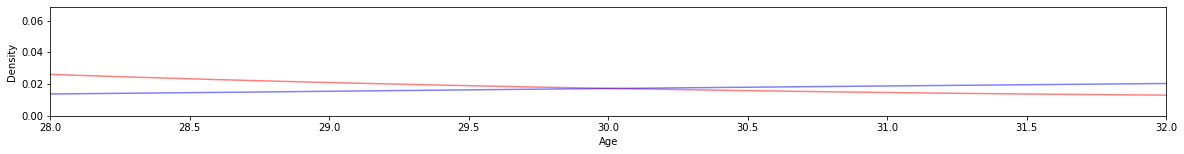

In [38]:
plt.figure(figsize=(20, 2))
plt.xlim(28, 32)
g = sns.kdeplot(df.loc[df['Response']==0, 'Age'], color='r', alpha=0.5)
g = sns.kdeplot(df.loc[df['Response']==1, 'Age'], color='b', alpha=0.5)

Feature **High_Response_Age** criada

In [39]:
print(f'A média de response entre os clientes com MENOS de 30 anos é: {round(df.loc[df["High_Age"]==0, "Response"].mean(), 2)}')
print(f'A média de response entre os clientes com MAIS de 30 anos é: {round(df.loc[df["High_Age"]==1, "Response"].mean(), 2)}')

A média de response entre os clientes com MENOS de 30 anos é: 0.04
A média de response entre os clientes com MAIS de 30 anos é: 0.18


A média de response dentre os clientes com mais de 30 anos é mais do que 50% superior em relação aos clientes com menos de 30 anos. Aceita e hipótese nula.

#### Driving_License

###### Principais Insights:
1. Correlações muito fracas
2. 99% dos clientes são habilitados
3. Habilitados apresentam 5% de interesse no produto, não habilitados apresentam 12% de interesse no produto.

###### General Analysis

In [40]:
df.corr()['Driving_License'].sort_values(ascending=False)[1:]

Policy_Sales_Channel                  0.043441
Vehicle_Age_                          0.029965
Previously_Insured                    0.015816
Response                              0.010615
Vintage                              -0.000611
Region_Code                          -0.000875
id                                   -0.001366
Annual_Premium_Variated              -0.002664
Log_Annual_Premium                   -0.007041
Annual_Premium                       -0.012356
High_Annual_Premium                  -0.016027
Region_Code_Response_Mean            -0.016770
Vehicle_Damage_                      -0.016974
Gender_                              -0.018290
Policy_Sales_Channel_Response_Mean   -0.033167
High_Age                             -0.037672
Age                                  -0.078918
Name: Driving_License, dtype: float64

Correlações muito fracas

In [41]:
print(f'{round(df["Driving_License"].mean(), 3)}% dos clientes são habilitados')

0.998% dos clientes são habilitados


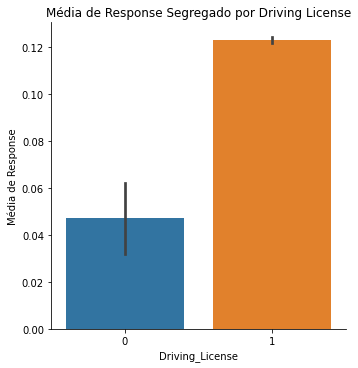

In [42]:
sns.catplot(x='Driving_License', y= 'Response', data=df, kind='bar')
plt.ylabel('Média de Response')
plt.title('Média de Response Segregado por Driving License');

In [43]:
print(f'Habilitados tem: {round(df.loc[df["Driving_License"]==0, "Response"].mean()*100, 2)}% de interesse no produto')
print(f'NÃO habilitados tem: {round(df.loc[df["Driving_License"]==1, "Response"].mean()*100, 2)}% de interesse no produto')

Habilitados tem: 4.71% de interesse no produto
NÃO habilitados tem: 12.32% de interesse no produto


#### Previously_Insured

###### Principais Insights:
1. 45% dos clientes já possuem seguro veicular
2. Clientes que já possuem seguro têm interesse quase zero pelo produto
3. Correlação muito forte negativa com Vehicle_Damage, fraca negativa com Response e Age, e fraca positiva com Policy_Sales_Channel

###### General Analysis

In [44]:
df.corr()['Previously_Insured'].sort_values(ascending=False)[1:]

Policy_Sales_Channel                  0.219889
Vehicle_Age_                          0.174019
Annual_Premium_Variated               0.087281
Log_Annual_Premium                    0.055315
Driving_License                       0.015816
Annual_Premium                        0.003194
id                                    0.003085
Vintage                               0.002204
Region_Code                          -0.024615
High_Annual_Premium                  -0.061018
Gender_                              -0.082508
Region_Code_Response_Mean            -0.180282
Age                                  -0.254810
High_Age                             -0.331682
Response                             -0.341880
Policy_Sales_Channel_Response_Mean   -0.418578
Vehicle_Damage_                      -0.824849
Name: Previously_Insured, dtype: float64

Correlação muito forte negativa com Vehicle_Damage, fraca negativa com Response e Age, e fraca positiva com Policy_Sales_Channel

In [45]:
df['Previously_Insured'].mean()

0.4582854710523093

45% dos clientes já sofreram danos veiculares

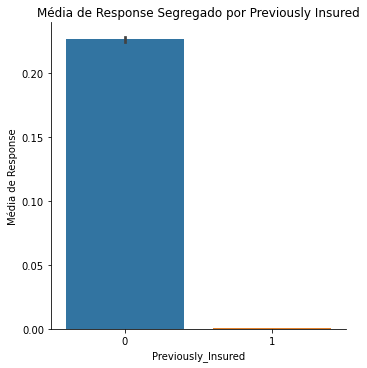

In [46]:
sns.catplot(x='Previously_Insured', y='Response', data=df, kind='bar')
plt.title('Média de Response Segregado por Previously Insured')
plt.ylabel('Média de Response');

In [47]:
df.loc[df['Previously_Insured']==1, 'Response'].mean()*100

0.0922444669224065

Clientes que possuem seguro veicular tem interesse quase zero no produto

#### Region_Code

###### Principais Insights:
1. 53 regiões
2. 28% dos clientes está contido na região 28. 50% dos dados estão contidos nas 5 regiões mais numerosas
3. A região 28 (mais importante) tem por volta de 18% de probabilidade de response, segunda melhor região, atrás apenas da região 38.
4. As regiões com probabilidade de response mais alto estão com por volta de 19%, as regiões com probabilidades mais baixas estã em por volta de 4%
5. Médias de response bastante distintas, com desvios padrões baixos

###### General Analysis:

In [48]:
df.corr()['Region_Code'].sort_values(ascending=False)[1:]

Region_Code_Response_Mean             0.080719
High_Age                              0.044174
Age                                   0.042919
Vehicle_Damage_                       0.028443
Policy_Sales_Channel_Response_Mean    0.027987
Response                              0.011201
Annual_Premium_Variated               0.005643
Log_Annual_Premium                    0.000786
Gender_                              -0.000045
Driving_License                      -0.000875
id                                   -0.001269
Vintage                              -0.002292
Annual_Premium                       -0.009788
Previously_Insured                   -0.024615
High_Annual_Premium                  -0.025943
Vehicle_Age_                         -0.027480
Policy_Sales_Channel                 -0.042988
Name: Region_Code, dtype: float64

Correlações muito fracas

In [49]:
df['Region_Code'].nunique()

53

53 categorias

In [50]:
df['Region_Code'].value_counts(normalize=True).head(5)

28.0    0.279372
8.0     0.089190
46.0    0.051989
41.0    0.047852
15.0    0.034962
Name: Region_Code, dtype: float64

In [51]:
df['Region_Code'].value_counts(normalize=True).tail(5)

1.0     0.002647
44.0    0.002163
42.0    0.001583
52.0    0.000741
51.0    0.000496
Name: Region_Code, dtype: float64

In [52]:
df['Region_Code'].value_counts(normalize=True).head(5).sum()

0.5033644511046711

28% dos clientes está contido na região 28. 50% dos dados estão contidos nas 5 regiões mais densas.

In [53]:
df.groupby('Region_Code', as_index=False).agg({'Response':'mean'}).sort_values('Response', ascending=False).head(5)

,Region_Code,Response
38,38.0,0.190955
28,28.0,0.188116
4,4.0,0.160395
19,19.0,0.159273
51,51.0,0.158824


In [54]:
df.groupby('Region_Code', as_index=False).agg({'Response':'mean'}).sort_values('Response', ascending=False).tail(5)

,Region_Code,Response
22,22.0,0.064157
50,50.0,0.063480
10,10.0,0.060308
44,44.0,0.041779
25,25.0,0.041407


As regiões com probabilidade de response mais alto estão com por volta de 19%, as regiões com probabilidades mais baixas estã em por volta de 4%

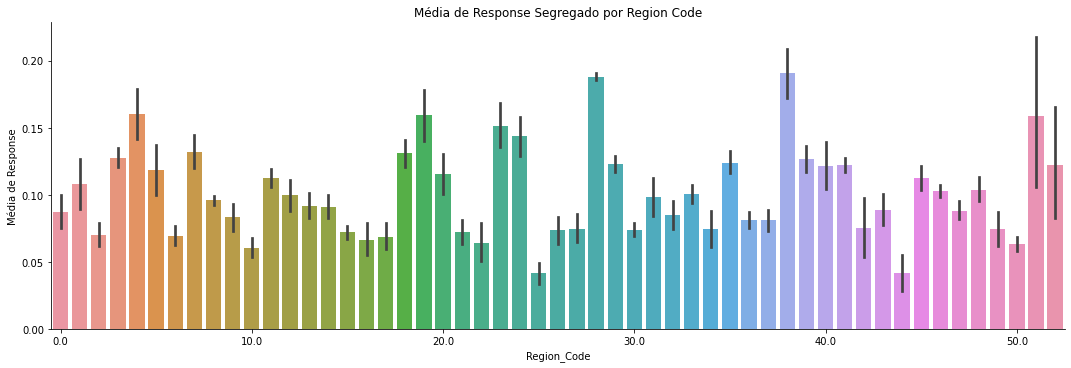

In [55]:
sns.catplot(x='Region_Code', y='Response', data=df, kind='bar', aspect=3)
plt.title('Média de Response Segregado por Region Code')
plt.xticks(range(0, int(df['Region_Code'].max()), 10))
plt.ylabel('Média de Response');

Médias de response bastante distintas, com desvios padrões baixos

#### Vehicle_Age

###### Principais insights:
1. Mais da metade dos clientes possuem carros com menos de 1 ano
2. Correlação moderada negativa com Age, fraca positiva com Policy_Sales_Channel
3. Médias de response bastante distintas

###### General Analysis

In [56]:
df.corr()['Vehicle_Age_'].sort_values(ascending=False)[1:]

Policy_Sales_Channel                  0.388688
Previously_Insured                    0.174019
Annual_Premium_Variated               0.090015
Log_Annual_Premium                    0.066641
Driving_License                       0.029965
Annual_Premium                        0.025154
Vintage                               0.003444
id                                   -0.001733
Region_Code                          -0.027480
High_Annual_Premium                  -0.031157
Response                             -0.104033
Gender_                              -0.112753
Vehicle_Damage_                      -0.173460
Region_Code_Response_Mean            -0.207109
Age                                  -0.521069
Policy_Sales_Channel_Response_Mean   -0.573135
High_Age                             -0.635078
Name: Vehicle_Age_, dtype: float64

Correlação moderada negativa com Age, fraca positiva com Policy_Sales_Channel

In [57]:
df['Vehicle_Age'].value_counts(normalize=True)

1-2 Year     0.525181
< 1 Year     0.432562
> 2 Years    0.042257
Name: Vehicle_Age, dtype: float64

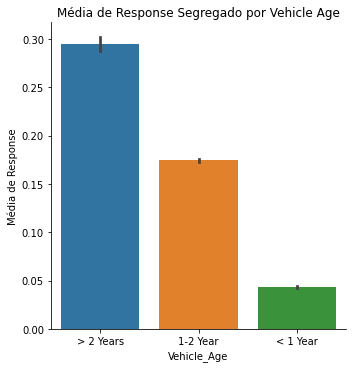

In [58]:
sns.catplot(x='Vehicle_Age', y='Response', data=df, kind='bar')
plt.ylabel('Média de Response')
plt.title('Média de Response Segregado por Vehicle Age');

Médias de response bastante distintas

#### Vehicle_Damage

###### Principais insights:
1. Balanceada
2. Correlação muito forte negativa com Previously_Insured, fraca negativa com Policy_Sales_Channel, fraca positiva com Response e Age
3. Clientes que já tiveram danos no seu veículo tem 24% de response, enquanto clientes que não tiveram danos têm por volta de 1%

###### General Analysis

In [59]:
df.corr()['Vehicle_Damage_'].sort_values(ascending=False)[1:]

Policy_Sales_Channel_Response_Mean    0.435632
Response                              0.355212
High_Age                              0.337513
Age                                   0.267332
Region_Code_Response_Mean             0.196153
Gender_                               0.091994
High_Annual_Premium                   0.069250
Region_Code                           0.028443
Annual_Premium                        0.010067
Vintage                              -0.001381
id                                   -0.001852
Driving_License                      -0.016974
Log_Annual_Premium                   -0.040395
Annual_Premium_Variated              -0.073027
Vehicle_Age_                         -0.173460
Policy_Sales_Channel                 -0.225116
Previously_Insured                   -0.824849
Name: Vehicle_Damage_, dtype: float64

Correlação muito forte negativa com Previously_Insured, fraca negativa com Policy_Sales_Channel, fraca positiva com Response e Age

In [60]:
df['Vehicle_Damage'].value_counts(normalize=True)

Yes    0.504974
No     0.495026
Name: Vehicle_Damage, dtype: float64

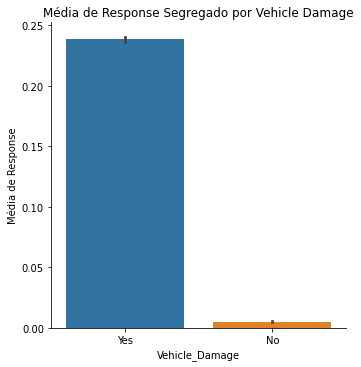

In [61]:
sns.catplot(x='Vehicle_Damage', y='Response', data=df, kind='bar')
plt.title('Média de Response Segregado por Vehicle Damage')
plt.ylabel('Média de Response');

In [62]:
print(f'Clientes que já tiveram danos tem: {round(df.loc[df["Vehicle_Damage"]=="Yes", "Response"].mean()*100, 2)}% de response')
print(f'Clientes que NÃO tiveram danos tem: {round(df.loc[df["Vehicle_Damage"]=="No", "Response"].mean()*100, 2)}% de response')

Clientes que já tiveram danos tem: 23.85% de response
Clientes que NÃO tiveram danos tem: 0.52% de response


Clientes que já tiveram danos no seu veículo tem 24% de response, enquanto clientes que não tiveram danos têm por volta de 1%

#### Annual_Premium

###### Principais insights:
1. 2799 em Annual_Premmium, não aparentam ser por conta de erros de input
2. Há dois grupos de clientes, um com valores fixos em 2630 dollares, e outro com valores contínuos e superiores, não há diferença significativa de média de interesse no produto entre os grupos
3. Aparentemente acima do terceiro quartil da distribuição há um interesse maior no produto

###### General Analysis

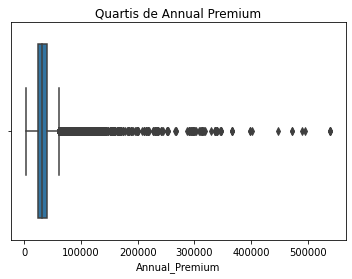

In [63]:
sns.boxplot(x='Annual_Premium', data=df)
plt.title('Quartis de Annual Premium');

Muitos outliers

In [64]:
índices, li, ls = buscar_outlier(df, 'Annual_Premium')

In [65]:
print(f'Há {len(índices)} outliers no total')

Há 1873 outliers no total


In [66]:
df.corr()['Annual_Premium'].sort_values(ascending=False)[1:]

Log_Annual_Premium                    0.874644
Annual_Premium_Variated               0.733993
High_Annual_Premium                   0.634657
Region_Code_Response_Mean             0.250434
Age                                   0.067474
Vehicle_Age_                          0.025154
Response                              0.023226
High_Age                              0.018217
Vehicle_Damage_                       0.010067
id                                    0.003838
Gender_                               0.003731
Previously_Insured                    0.003194
Policy_Sales_Channel_Response_Mean    0.000589
Vintage                              -0.000988
Region_Code                          -0.009788
Driving_License                      -0.012356
Policy_Sales_Channel                 -0.113155
Name: Annual_Premium, dtype: float64

Correlações muito fracas

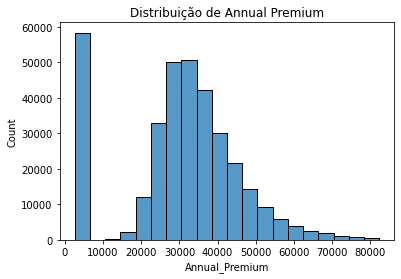

In [67]:
sns.histplot(df.drop(índices)['Annual_Premium'], bins=20)
plt.title('Distribuição de Annual Premium');

In [68]:
df['Annual_Premium'].value_counts(normalize=True).head(5)

2630.0     0.169983
69856.0    0.000370
39008.0    0.000102
45179.0    0.000099
38452.0    0.000099
Name: Annual_Premium, dtype: float64

17% dos clientes estão contidos em um valor discreto de 2630 dollares. Um estudo separadamente para este grupo pode ser interessante.

In [69]:
print(f'A média de interesse no produto do grupo de clientes com valor FIXO de seguro: {round(df.loc[df["Annual_Premium"]==2630, "Response"].mean()*100, 2)}%')
print(f'A média de interesse no produto do grupo de clientes com valor VARIÁVEL SUPERIOR de seguro: {round(df.loc[df["Annual_Premium"]!=2630, "Response"].mean()*100, 2)}%')

A média de interesse no produto do grupo de clientes com valor FIXO de seguro: 13.19%
A média de interesse no produto do grupo de clientes com valor VARIÁVEL SUPERIOR de seguro: 12.12%


O interesse no produto não é significativamente diferente entre os dois grupos de clientes

**Nicho Variável**

Para uma melhor visualização, os dados serão filtrados provisioriamente até 100000 dollares

In [70]:
temp = df.loc[(df['Annual_Premium']>2630)&(df['Annual_Premium']<100000)]

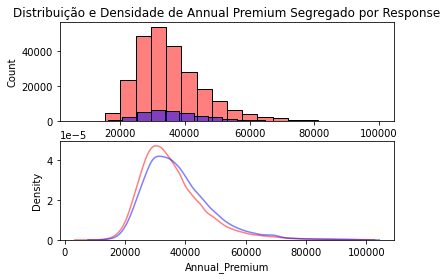

In [71]:
plt.subplot(2, 1, 1)
plt.title('Distribuição e Densidade de Annual Premium Segregado por Response')
g = sns.histplot(temp.loc[temp['Response']==0, 'Annual_Premium'], color='r', alpha=0.5, bins=20)
g = sns.histplot(temp.loc[temp['Response']==1, 'Annual_Premium'], color='b', alpha=0.5, bins=20)
plt.subplot(2, 1, 2)
g = sns.kdeplot(temp.loc[temp['Response']==0, 'Annual_Premium'], color='r', alpha=0.5)
g = sns.kdeplot(temp.loc[temp['Response']==1, 'Annual_Premium'], color='b', alpha=0.5)

Aparentemente acima do terceiro quartil da distribuição há um interesse maior no produto

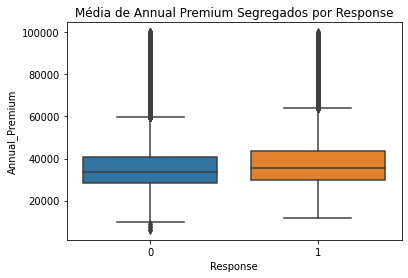

In [72]:
plt.title('Média de Annual Premium Segregados por Response')
sns.boxplot(x='Response', y='Annual_Premium', data=temp);

Sem diferença significativa

**Nicho Fixo**

In [73]:
temp = df[df['Annual_Premium']==2630]

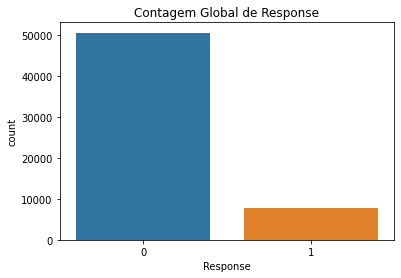

In [74]:
plt.title('Contagem Global de Response')
sns.countplot(x='Response', data=temp);

###### Teste de hipótese 4.3

Feature **High_Annual_Premium** criada

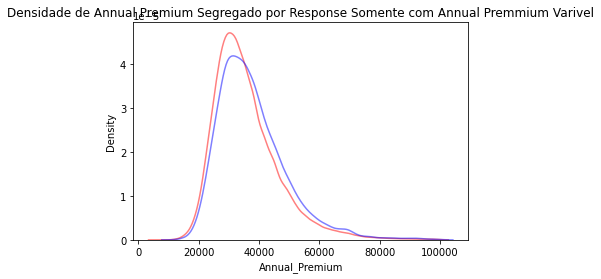

In [75]:
temp = df[df['Annual_Premium']<100000]
plt.title('Densidade de Annual Premium Segregado por Response Somente com Annual Premmium Varivel')
g = sns.kdeplot(temp.loc[(temp['Annual_Premium_Variated']==1)&(temp['Response']==0), 'Annual_Premium'], color='r', alpha=0.5)
g = sns.kdeplot(temp.loc[(temp['Annual_Premium_Variated']==1)&(temp['Response']==1), 'Annual_Premium'], color='b', alpha=0.5);

Adicionando aleatoriedade

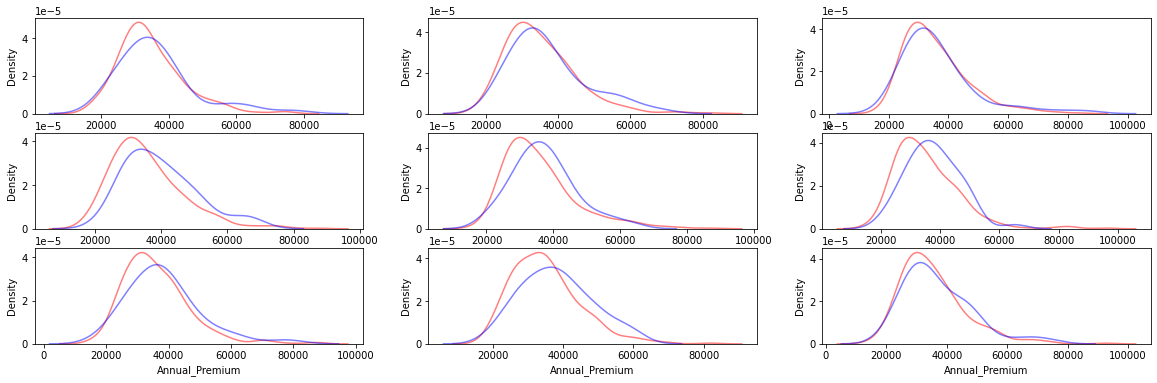

In [76]:
temp = df[df['Annual_Premium']<100000]
plt.figure(figsize=(20, 6))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    índices_aleatórios = np.random.choice(temp.index, 500, replace=False)
    temp1 = temp.loc[índices_aleatórios]
    g = sns.kdeplot(temp1.loc[(temp1['Annual_Premium_Variated']==1)&(temp1['Response']==0), 'Annual_Premium'], color='r', alpha=0.5)
    g = sns.kdeplot(temp1.loc[(temp1['Annual_Premium_Variated']==1)&(temp1['Response']==1), 'Annual_Premium'], color='b', alpha=0.5);

Em um dado acima do terceiro quartil, parece haver maior interesse no produto, porém adicionando-se aleatoriedade, tal fato não demonstra ser estável, sendo comprovado em algumas amostras e em outras não.

In [77]:
print(f'A média de Response entre os clientes que fazem parte dos High_Annual_Premium: {round(df.loc[df["High_Annual_Premium"]==1, "Response"].mean(), 2)}')
print(f'A média de Response entre os clientes que NÃO fazem parte dos High_Annual_Premium: {round(df.loc[df["High_Annual_Premium"]==0, "Response"].mean(), 2)}')

A média de Response entre os clientes que fazem parte dos High_Annual_Premium: 0.15
A média de Response entre os clientes que NÃO fazem parte dos High_Annual_Premium: 0.12


A diferença entre as médias de Response foi de por volta de 20% entre os grupos, portanto, rejeita a hipótese nula.

#### Policy_Sales_Channel

###### Main insights:
1. Há 157 Policy_Sales_Channel e aproximadamente um terço das amostras está contido no canal 152
2. 5 categorias contém 84.19% do total de clientes
3. Correlação moderada negativa com Age, correlação fraca negativa com Vehicle_Damage, correlação fraca positiva com Vehicle_Age e Previously_Insured
4. Médias de response por canais de Policy_Sales_Channel bastante distintas
5. Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

###### General Analysis

In [78]:
df.corr()['Policy_Sales_Channel'].sort_values(ascending=False)[1:]

Vehicle_Age_                          0.388688
Previously_Insured                    0.219889
Driving_License                       0.043441
Vintage                               0.000040
id                                   -0.002598
Annual_Premium_Variated              -0.015250
Region_Code                          -0.042988
Log_Annual_Premium                   -0.061268
Gender_                              -0.111758
Annual_Premium                       -0.113155
Response                             -0.140142
High_Annual_Premium                  -0.147865
Vehicle_Damage_                      -0.225116
Region_Code_Response_Mean            -0.286261
Policy_Sales_Channel_Response_Mean   -0.530596
High_Age                             -0.552789
Age                                  -0.578500
Name: Policy_Sales_Channel, dtype: float64

Correlação moderada negativa com Age, correlação fraca negativa com Vehicle_Damage, correlação fraca positiva com Vehicle_Age e Previously_Insured

In [79]:
df['Policy_Sales_Channel'].value_counts(normalize=True).head(5)

152.0    0.353547
26.0     0.209115
124.0    0.194182
160.0    0.057333
156.0    0.027991
Name: Policy_Sales_Channel, dtype: float64

In [80]:
canais_mais_utilizados = df['Policy_Sales_Channel'].value_counts(normalize=True).head(5).index

In [81]:
print(f'5 categorias contém {round(df["Policy_Sales_Channel"].value_counts(normalize=True).head(5).sum()*100, 2)}% do total de clientes')

5 categorias contém 84.22% do total de clientes


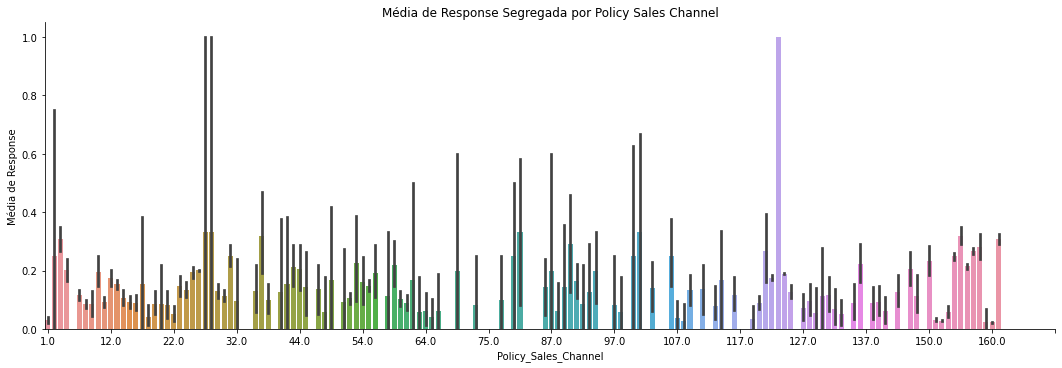

In [82]:
sns.catplot(x='Policy_Sales_Channel', y='Response', data=df, kind='bar', aspect=3)
plt.xticks(range(0, int(df['Policy_Sales_Channel'].max()), 10))
plt.title('Média de Response Segregada por Policy Sales Channel')
plt.ylabel('Média de Response');

Médias de response por canais de Policy_Sales_Channel bastante distintas

In [83]:
temp = df.groupby('Policy_Sales_Channel', as_index=False).agg({'Response':'count'})
temp.rename(columns={'Response':'Response_Count'}, inplace=True)

temp2 = df.groupby('Policy_Sales_Channel', as_index=False).agg({'Response':'mean'})
temp2.rename(columns={'Response':'Response_Mean'}, inplace=True)

temp3 = temp.merge(temp2, how='left', on='Policy_Sales_Channel')
temp3.sort_values('Response_Count', ascending=False).head(5)

,Policy_Sales_Channel,Response_Count,Response_Mean
142,152.0,121266,0.028532
24,26.0,71726,0.200402
117,124.0,66604,0.189613
150,160.0,19665,0.022070
146,156.0,9601,0.214561


Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

In [84]:
del(temp, temp2, temp3)

#### Vintage

###### Main insights:
1. Feature categórica, há 290 categorias em Vintage

###### General Analysis

In [85]:
df.corr()['Vintage'].sort_values(ascending=False)[1:]

Vehicle_Age_                          0.003444
Previously_Insured                    0.002204
High_Annual_Premium                   0.000727
Region_Code_Response_Mean             0.000327
Policy_Sales_Channel                  0.000040
Driving_License                      -0.000611
Annual_Premium                       -0.000988
Response                             -0.001069
id                                   -0.001120
Age                                  -0.001344
Vehicle_Damage_                      -0.001381
Log_Annual_Premium                   -0.002088
High_Age                             -0.002194
Region_Code                          -0.002292
Annual_Premium_Variated              -0.002517
Policy_Sales_Channel_Response_Mean   -0.002585
Gender_                              -0.003352
Name: Vintage, dtype: float64

Correlações muito fracas

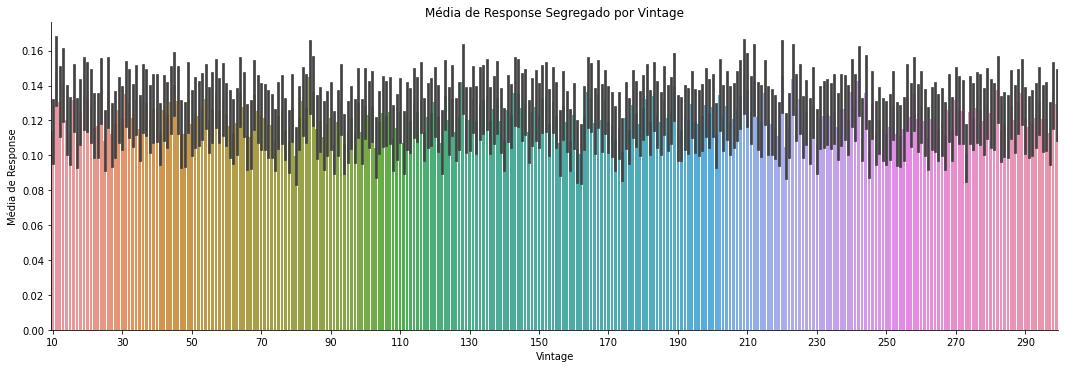

In [86]:
sns.catplot(x='Vintage', y='Response', data=df, kind='bar', aspect=3)
plt.title('Média de Response Segregado por Vintage')
plt.ylabel('Média de Response')
plt.xticks(range(0, df['Vintage'].max(), 20));

Muito ruidoso, os desvios padrões colocam tudo no mesmo nível.

## 5.4 Removing expendable features

In [87]:
df.drop(['High_Annual_Premium', 'Annual_Premium_Variated'], axis=1, inplace=True)

Features **High_Annual_Premium e Annual_Premium_Variated** foram testadas pelo ml_modeling, não contribuíram com o mocelo, portanto serão removidas.

## 5.5 Principais Features e Importâncias

### 5.5.1 Importances

O código deste tópico poderá ser rodado apenas após os outros notebooks do projeto serem processados.

In [88]:
# ranking = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\data\\interim\\ranking_feature_selection.pkl', 'rb'))

# ranking

1. As colunas "correlations", "importance_rf" e "importance_xgb" são quantitativas e estão na mesma escala
2. A coluna "rfe_xgb" é tipo tipo ranking, quanto menor o número melhor a colocação
3. A coluna "boruta" é binária, 1 significa uma feature relevante e 2 uma feature a ser dispensada

In [89]:
# ranking_1 = ranking[['correlations', 'importance_rf', 'importance_xgb']].copy()
# ranking_1['total'] = np.sum(ranking_1, axis=1)

# ranking_1.sort_values('total', ascending=False, inplace=True)

# ranking_1.drop('total', axis=1).plot(kind='bar', stacked=True)
# plt.title('Importancias das features')
# plt.ylabel('Soma das Importancias');

# 6.0 Exportings

###### 6.1 Dataframe

In [90]:
pickle.dump(df, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\data\\interim\\df_to_data_preparation.pkl', 'wb'))
print('Criado df processado para seguir para preparação de dados e ML')

Criado df processado para seguir para preparação de dados e ML


###### 6.2 Encodings

In [91]:
pickle.dump(le_gender, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\webapp\\le_gender.pkl', 'wb'))
pickle.dump(le_gender, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\src\\features\\le_gender.pkl', 'wb'))

pickle.dump(le_vehicle_damage, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\webapp\\le_vehicle_damage.pkl', 'wb'))
pickle.dump(le_vehicle_damage, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\src\\features\\le_vehicle_damage.pkl', 'wb'))

pickle.dump(le_vehicle_age, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\webapp\\le_vehicle_age.pkl', 'wb'))
pickle.dump(le_vehicle_age, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\src\\features\\le_vehicle_age.pkl', 'wb'))

###### 6.3 Features

In [92]:
# pickle policy_sales_channel map
pickle.dump(map_policy_sales_channel_response_mean, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\webapp\\map_policy_sales_channel_response_mean.pkl', 'wb'))
pickle.dump(map_policy_sales_channel_response_mean, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\insurance_sales_predict\\src\\features\\map_policy_sales_channel_response_mean.pkl', 'wb'))
# pickle region_code map
pickle.dump(map_region_code_response_mean, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\webapp\\map_region_code_response_mean.pkl', 'wb'))
pickle.dump(map_region_code_response_mean, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\src\\features\\map_region_code_response_mean.pkl', 'wb'))

###### 6.4 Test

In [93]:
pickle.dump(test, open('D:\\My Drive\\Pessoal\\Projetos\\insurance_sales_predict\\insurance_sales_predict\\data\\raw\\test.pkl', 'wb'))

# Time

In [94]:
print(f'O tempo de processamento do projeto foi de: {int(round(time.time()-time_agora, 2)/60)} minutos')

O tempo de processamento do projeto foi de: 0 minutos
